In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
print('Environment ready.')

Environment ready.


## 1–2) Dataset Acquisition & Loading

In [2]:
from sklearn.datasets import fetch_openml
try:
    mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
    X = mnist.data.astype('float32')
    y = mnist.target.astype('int64')
    print('Loaded MNIST via OpenML:', X.shape, 'targets:', len(np.unique(y)))
except Exception as e:
    print('OpenML fetch failed:', e)
    print('Falling back to Keras MNIST...')
    try:
        from tensorflow.keras.datasets import mnist as keras_mnist
        (X_train_k, y_train_k), (X_test_k, y_test_k) = keras_mnist.load_data()
        X = np.concatenate([X_train_k, X_test_k], axis=0)
        y = np.concatenate([y_train_k, y_test_k], axis=0)
        X = X.reshape((X.shape[0], -1)).astype('float32')
        y = y.astype('int64')
        print('Loaded MNIST via Keras:', X.shape, 'targets:', len(np.unique(y)))
    except Exception as e2:
        raise RuntimeError('Failed to load MNIST from both OpenML and Keras. Please ensure internet access and try again.\n' + str(e2))

Loaded MNIST via OpenML: (70000, 784) targets: 10


## 3) Data Exploration

In [3]:
import math
df = pd.DataFrame(X)
df['target'] = y
n_samples, n_features_total = df.shape
n_features = n_features_total - 1
classes = sorted(df['target'].unique())
print(f'Total samples: {n_samples}')
print(f'Feature columns (pixels): {n_features}')
print(f'Target classes: {classes}')
display(df.head())
display(df['target'].value_counts().sort_index())

Total samples: 70000
Feature columns (pixels): 784
Target classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9


,count
target,
0,6903
1,7877
2,6990
3,7141
4,6824
5,6313
6,6876
7,7293
8,6825


## 4) Data Visualization — Sample Digit Images

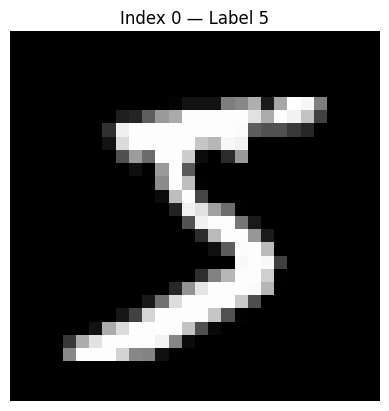

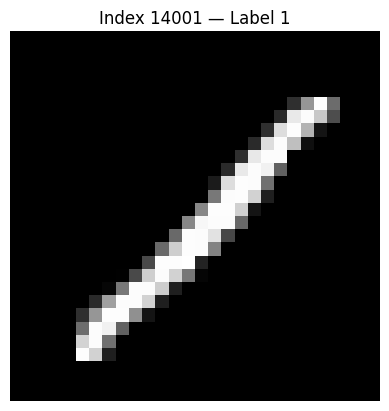

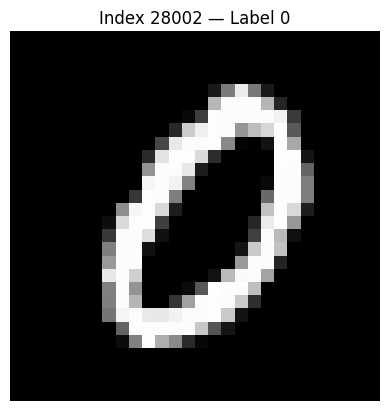

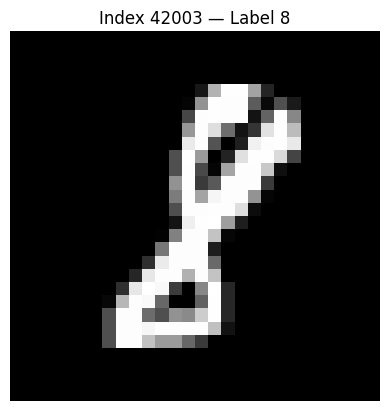

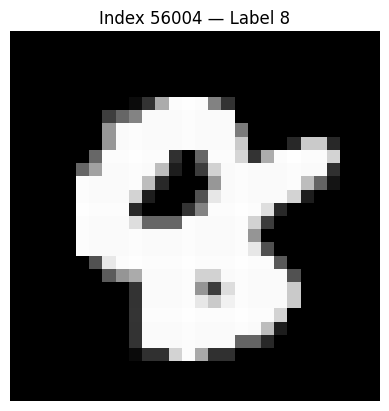

In [4]:
def show_digit(idx):
    img = X[idx].reshape(28, 28)
    plt.figure()
    plt.imshow(img, cmap='gray')
    plt.title(f'Index {idx} — Label {y[idx]}')
    plt.axis('off')
    plt.show()

for i in range(5):
    show_digit(i * (len(X)//5 + 1))

## 5) Data Preprocessing

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print('Train:', X_train.shape, 'Test:', X_test.shape)

Train: (56000, 784) Test: (14000, 784)


## 6) Model Definitions
- Logistic Regression
- Support Vector Machine (SVM)
- Decision Tree Classifier

In [6]:
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000, n_jobs=-1))
])

pipe_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC())
])

pipe_dt = Pipeline([
    ('clf', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid_lr = {
    'clf__C': [1],                 # single reasonable default
    'clf__penalty': ['l2'],        # logistic regression default
    'clf__solver': ['lbfgs']       # works well for small/medium datasets
}

param_grid_svm = {
    'clf__kernel': ['rbf'],        # standard choice
    'clf__C': [1],                 # default C
    'clf__gamma': ['scale']        # default gamma
}

param_grid_dt = {
    'clf__criterion': ['gini'],    # default split criterion
    'clf__max_depth': [None],      # no restriction
    'clf__min_samples_split': [2]  # default
}

print('Pipelines and grids ready.')

Pipelines and grids ready.


## 7) Hyperparameter Optimization (Grid Search)

In [7]:
def run_grid(model, params, name):
    grid = GridSearchCV(model, params, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)
    print(f'Best {name} params:', grid.best_params_)
    print(f'Best {name} CV accuracy: {grid.best_score_:.4f}')
    return grid.best_estimator_, grid.best_params_, grid.best_score_

best_lr, best_lr_params, best_lr_cv = run_grid(pipe_lr, param_grid_lr, 'LogReg')
best_svm, best_svm_params, best_svm_cv = run_grid(pipe_svm, param_grid_svm, 'SVM')
best_dt, best_dt_params, best_dt_cv = run_grid(pipe_dt, param_grid_dt, 'DecisionTree')

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best LogReg params: {'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Best LogReg CV accuracy: 0.9086
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best SVM params: {'clf__C': 1, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}
Best SVM CV accuracy: 0.9598
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best DecisionTree params: {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__min_samples_split': 2}
Best DecisionTree CV accuracy: 0.8596


## 8) Training Evaluation

In [8]:
def evaluate(name, model, X, y):
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred, average='macro', zero_division=0)
    rec = recall_score(y, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y, y_pred, average='macro', zero_division=0)
    print(f'\n{name} — Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}')
    print('Confusion Matrix:\n', cm)
    return {'model': name, 'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1}

train_scores = []
train_scores.append(evaluate('Logistic Regression (best)', best_lr, X_train, y_train))
train_scores.append(evaluate('SVM (best)', best_svm, X_train, y_train))
train_scores.append(evaluate('Decision Tree (best)', best_dt, X_train, y_train))
pd.DataFrame(train_scores)


Logistic Regression (best) — Accuracy: 0.9447, Precision: 0.9441, Recall: 0.9440, F1: 0.9440
Confusion Matrix:
 [[5421    1   15    7    4   21   19    2   24    8]
 [   1 6188   21   12    3   19    4    9   38    7]
 [  19   25 5208   65   50   19   40   50  100   16]
 [  12   14  109 5259    6  132   13   30   96   42]
 [   8   17   21    7 5194    5   28   21   22  136]
 [  31   13   30  118   45 4617   63    9   99   25]
 [  21    7   34    3   28   51 5339    3   15    0]
 [   5   13   46   15   36    9    3 5537   15  155]
 [  23   73   57  120   18   98   30   16 4976   49]
 [  15   17   13   62  106   21    0  132   36 5165]]

SVM (best) — Accuracy: 0.9858, Precision: 0.9858, Recall: 0.9857, F1: 0.9858
Confusion Matrix:
 [[5487    3    3    2    3    5    8    1    9    1]
 [   1 6255   14    4    3    1    2    6    6   10]
 [   9    6 5533    4    8    2    1   13   14    2]
 [   0    6   19 5604    3   21    0   14   33   13]
 [   1    7    8    0 5394    0    5    5    3 

,model,acc,prec,rec,f1
0,Logistic Regression (best),0.944714,0.944075,0.943998,0.944023
1,SVM (best),0.985821,0.985820,0.985743,0.985777
2,Decision Tree (best),1.000000,1.000000,1.000000,1.000000


## 9) Testing Evaluation + Bootstrapping 95% CIs

In [9]:
def bootstrap_metrics(model, X, y, n_boot=500, random_state=RANDOM_STATE):
    rng = np.random.RandomState(random_state)
    n = len(y)
    accs, precs, recs = [], [], []
    y_pred_full = model.predict(X)
    # Base (full) metrics
    base = {
        'acc': accuracy_score(y, y_pred_full),
        'prec': precision_score(y, y_pred_full, average='macro', zero_division=0),
        'rec': recall_score(y, y_pred_full, average='macro', zero_division=0),
        'f1': f1_score(y, y_pred_full, average='macro', zero_division=0)
    }
    for _ in range(n_boot):
        idx = rng.randint(0, n, size=n)
        y_b = y[idx]
        yhat_b = y_pred_full[idx]
        accs.append(accuracy_score(y_b, yhat_b))
        precs.append(precision_score(y_b, yhat_b, average='macro', zero_division=0))
        recs.append(recall_score(y_b, yhat_b, average='macro', zero_division=0))
    def ci(a):
        low, high = np.percentile(a, [2.5, 97.5])
        return float(np.mean(a)), float(low), float(high)
    acc_m, acc_l, acc_h = ci(accs)
    prec_m, prec_l, prec_h = ci(precs)
    rec_m, rec_l, rec_h = ci(recs)
    return base, {
        'acc_mean': acc_m, 'acc_ci_low': acc_l, 'acc_ci_high': acc_h,
        'prec_mean': prec_m, 'prec_ci_low': prec_l, 'prec_ci_high': prec_h,
        'rec_mean': rec_m, 'rec_ci_low': rec_l, 'rec_ci_high': rec_h,
    }

test_rows = []
for name, model in [
    ('Logistic Regression (best)', best_lr),
    ('SVM (best)', best_svm),
    ('Decision Tree (best)', best_dt)
]:
    base, ci = bootstrap_metrics(model, X_test, y_test, n_boot=500)
    row = {'model': name}
    row.update({f'test_{k}': v for k, v in base.items()})
    row.update(ci)
    test_rows.append(row)

test_df = pd.DataFrame(test_rows)
display(test_df)

,model,test_acc,test_prec,test_rec,test_f1,acc_mean,acc_ci_low,acc_ci_high,prec_mean,prec_ci_low,prec_ci_high,rec_mean,rec_ci_low,rec_ci_high
0,Logistic Regression (best),0.916071,0.915156,0.915013,0.915005,0.916007,0.911748,0.920259,0.915108,0.910949,0.919306,0.914969,0.910769,0.919086
1,SVM (best),0.964214,0.964615,0.963849,0.964096,0.964213,0.961071,0.967214,0.964613,0.961581,0.967736,0.963854,0.960741,0.966890
2,Decision Tree (best),0.874214,0.872423,0.872469,0.872389,0.874168,0.868857,0.879038,0.872404,0.866947,0.877316,0.872446,0.867068,0.877260


## 10) Model Comparison & Discussion

In [10]:
train_df = pd.DataFrame(train_scores)
merged = pd.merge(train_df, test_df, on='model', how='inner')
display(merged)

def gap_comment(train_acc, test_acc):
    gap = train_acc - test_acc
    if gap > 0.05:
        return 'Likely overfitting (large train>test gap).'
    elif gap < -0.01:
        return 'Unusual: test > train; possibly regularization/variance effects.'
    else:
        return 'No strong over/underfitting signal from accuracy gap.'

for _, r in merged.iterrows():
    print(f"{r['model']}:\n  Train Acc={r['acc']:.4f} | Test Acc={r['test_acc']:.4f} => {gap_comment(r['acc'], r['test_acc'])}")

,model,acc,prec,rec,f1,test_acc,test_prec,test_rec,test_f1,acc_mean,acc_ci_low,acc_ci_high,prec_mean,prec_ci_low,prec_ci_high,rec_mean,rec_ci_low,rec_ci_high
0,Logistic Regression (best),0.944714,0.944075,0.943998,0.944023,0.916071,0.915156,0.915013,0.915005,0.916007,0.911748,0.920259,0.915108,0.910949,0.919306,0.914969,0.910769,0.919086
1,SVM (best),0.985821,0.985820,0.985743,0.985777,0.964214,0.964615,0.963849,0.964096,0.964213,0.961071,0.967214,0.964613,0.961581,0.967736,0.963854,0.960741,0.966890
2,Decision Tree (best),1.000000,1.000000,1.000000,1.000000,0.874214,0.872423,0.872469,0.872389,0.874168,0.868857,0.879038,0.872404,0.866947,0.877316,0.872446,0.867068,0.877260


Logistic Regression (best):
  Train Acc=0.9447 | Test Acc=0.9161 => No strong over/underfitting signal from accuracy gap.
SVM (best):
  Train Acc=0.9858 | Test Acc=0.9642 => No strong over/underfitting signal from accuracy gap.
Decision Tree (best):
  Train Acc=1.0000 | Test Acc=0.8742 => Likely overfitting (large train>test gap).
